# 1. Problem Set 2: Data manipulation with `pandas`

**Total points**: 53

By investigating disparities in sentencing between black defendants and white defendants, this problem set will give you practice with:

- Data wrangling with pandas: groupby, subsetting, sorting, etc.
- Defining your own functions
- Visualizing trends in data

We will use the Cook County, Illinois (which contains Chicago) sentencing dataset. This analysis could be extended to study Hispanic defendants or, in a different jurisdiction, Asian and other minoritized groups.

This dataset reports the sentence given to defendants convicted of different crimes, and you can find [the data codebook here](https://datacatalog.cookcountyil.gov/api/views/tg8v-tm6u/files/8597cdda-f7e1-44d1-b0ce-0a4e43f8c980?download=true&filename=CCSAO%20Data%20Glossary.pdf) and the latest on these data [at the official website](https://datacatalog.cookcountyil.gov/Courts/Sentencing/tg8v-tm6u).

**Details if interested in digging deeper** (optional): There is a lot to think about here in terms of (1) how we might measure disparities, and (2) what factors you would want to adjust for when deciding whether two defendants are 'similarly situated' but for their race. You can read more technical coverage in the following sources:

- [Review of sentencing disparities research](https://www.journals.uchicago.edu/doi/full/10.1086/701505)
- [Discussion of causal model/blinding race at charging stage of the prosecutorial process](https://5harad.com/papers/blind-charging.pdf)
- [Discussion of measuring discrimination in policing that can generalize to the sentencing case](https://www.annualreviews.org/doi/abs/10.1146/annurev-criminol-011518-024731)
- [General discussion of causal challenges in measuring between-group disparities](https://osf.io/preprints/socarxiv/gx4y3/)

**One major caveat**: when comparing whether two similar defendants received different sentences, we're missing one important attribute that influences sentencing: the defendant's criminal history. This influences sentencing both through sentencing guidelines, which can prescribe longer sentences for those who have certain types of prior convictions, and through judicial discretion if judges are more lenient with first-time defendants. The above sources discuss how much we want to "control away" for this prior history, since if we think there are racial biases in which defendants, conditional on *committing* a crime, are arrested and charged, we may not want to adjust for that factor.

# 0. Load packages and imports (2 points total)

In [1]:
## basic functionality
import pandas as pd
import numpy as np
import re

## for plotting; can also use matplotlib or seaborn
## note: for plotnine, you likely need to install using pip or conda
## if not using plotnine for viz, no need to import it (can comment out next two lines)
# import plotnine
# from plotnine import *
import matplotlib.pyplot as plt

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## datetime util
from dateutil.relativedelta import relativedelta

## 0.1 Load the raw data (1 point)

Use `pd.read_csv` to load the `sentencing_asof0405.csv` data. To get this, unzip `pset2_inputdata.zip` (try the `unzip` shell command). Be sure to use relative path names (e.g., `../data/file.csv` goes up a level and looks inside the `data/` folder for `file.csv`) and **don't hard code** your user-specific path name (e.g., `C:/files/data/file.csv`). If you can't find the file,  double-check you're looking in the right directory (the `os` library in Python can help with this).

*Notes*: You may receive a warning about mixed data types upon import; feel free to ignore, or call `low_memory=False` as a parameter.

**Hint:**
You may receive a warning about mixed data types upon loading the .csv file into pandas; feel free to ignore, or call `low_memory=False` as a parameter.

In [2]:
## your code here loading the data
sentencing = pd.read_csv("./pset2_inputdata/sentencing_asof0405.csv", low_memory=False)

## 0.2 Inspect the data (1 points)

Print the head, dimensions, and info for the data.

In [3]:
## your code here inspecting the data
sentencing
sentencing.shape
sentencing.info()

,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,INCIDENT_CITY,INCIDENT_BEGIN_DATE,INCIDENT_END_DATE,LAW_ENFORCEMENT_AGENCY,LAW_ENFORCEMENT_UNIT,ARREST_DATE,FELONY_REVIEW_DATE,FELONY_REVIEW_RESULT,ARRAIGNMENT_DATE,UPDATED_OFFENSE_CATEGORY
0,149765331439,175691153649,8/15/1984 12:00:00 AM,PROMIS Conversion,False,50510112469,116304211997,FIRST DEGREE MURDER,2,12/17/2014 12:00:00 AM,...,NaN,8/9/1984 12:00:00 AM,NaN,CHICAGO POLICE DEPT,NaN,8/15/1984 12:00:00 AM,08/15/1984 12:00:00 AM,Charge(S) Approved,9/21/1984 12:00:00 AM,Homicide
1,149765331439,175691153649,8/15/1984 12:00:00 AM,PROMIS Conversion,False,50510213021,98265074680,HOME INVASION,14,12/17/2014 12:00:00 AM,...,NaN,8/9/1984 12:00:00 AM,NaN,CHICAGO POLICE DEPT,NaN,8/15/1984 12:00:00 AM,08/15/1984 12:00:00 AM,Charge(S) Approved,9/21/1984 12:00:00 AM,Homicide
2,149765331439,175691153649,8/15/1984 12:00:00 AM,PROMIS Conversion,False,50516447217,131972895911,FIRST DEGREE MURDER,4,12/17/2014 12:00:00 AM,...,NaN,8/9/1984 12:00:00 AM,NaN,CHICAGO POLICE DEPT,NaN,8/15/1984 12:00:00 AM,08/15/1984 12:00:00 AM,Charge(S) Approved,9/21/1984 12:00:00 AM,Homicide
3,149765331439,175691153649,8/15/1984 12:00:00 AM,PROMIS Conversion,False,50516497493,131966356472,FIRST DEGREE MURDER,5,12/17/2014 12:00:00 AM,...,NaN,8/9/1984 12:00:00 AM,NaN,CHICAGO POLICE DEPT,NaN,8/15/1984 12:00:00 AM,08/15/1984 12:00:00 AM,Charge(S) Approved,9/21/1984 12:00:00 AM,Homicide
4,149765331439,175691153649,8/15/1984 12:00:00 AM,PROMIS Conversion,False,50516648320,98059642859,HOME INVASION,13,12/17/2014 12:00:00 AM,...,NaN,8/9/1984 12:00:00 AM,NaN,CHICAGO POLICE DEPT,NaN,8/15/1984 12:00:00 AM,08/15/1984 12:00:00 AM,Charge(S) Approved,9/21/1984 12:00:00 AM,Homicide
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248141,445516248775,905289187184,2/3/2021 12:00:00 AM,Home Invasion,True,447867029248,836341344232,AGGRAVATED UNLAWFUL USE OF WEAPON,1,3/19/2021 12:00:00 AM,...,Des Plaines,2/2/2021 12:00:00 AM,NaN,DES PLAINES PD,NaN,2/2/2021 2:20:00 PM,02/04/2021 12:00:00 AM,Approved,3/19/2021 12:00:00 AM,UUW - Unlawful Use of Weapon
248142,445527409730,905322500577,2/4/2021 12:00:00 AM,Domestic Battery,True,447970697900,836537247156,DOMESTIC BATTERY,1,3/23/2021 12:00:00 AM,...,Franklin Park,2/3/2021 12:00:00 AM,NaN,COOK COUNTY SHERIFF'S POLICE PATROL MAYWOOD (I...,NaN,2/9/2021 11:25:00 AM,02/10/2021 12:00:00 AM,Approved,3/11/2021 12:00:00 AM,Domestic Battery
248143,445587767000,905518794790,2/9/2021 12:00:00 AM,Driving With Suspended Or Revoked License,True,447955866546,837760215766,DRIVING ON SUSPENDED LICENSE,1,3/11/2021 12:00:00 AM,...,Berwyn,7/28/2020 12:00:00 AM,NaN,BERWYN PD,NaN,2/4/2021 4:35:00 PM,NaN,NaN,3/9/2021 12:00:00 AM,Driving With Suspended Or Revoked License
248144,445592613204,905533705601,2/9/2021 12:00:00 AM,Driving With Suspended Or Revoked License,True,447966223356,837758347354,DRIVING ON SUSPENDED LICENSE,1,3/11/2021 12:00:00 AM,...,Berwyn,6/17/2020 12:00:00 AM,NaN,BERWYN PD,NaN,2/4/2021 4:35:00 PM,NaN,NaN,3/9/2021 12:00:00 AM,Driving With Suspended Or Revoked License


(248146, 41)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248146 entries, 0 to 248145
Data columns (total 41 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   CASE_ID                            248146 non-null  int64  
 1   CASE_PARTICIPANT_ID                248146 non-null  int64  
 2   RECEIVED_DATE                      248146 non-null  object 
 3   OFFENSE_CATEGORY                   248146 non-null  object 
 4   PRIMARY_CHARGE_FLAG                248146 non-null  bool   
 5   CHARGE_ID                          248146 non-null  int64  
 6   CHARGE_VERSION_ID                  248146 non-null  int64  
 7   DISPOSITION_CHARGED_OFFENSE_TITLE  248146 non-null  object 
 8   CHARGE_COUNT                       248146 non-null  int64  
 9   DISPOSITION_DATE                   248146 non-null  object 
 10  DISPOSITION_CHARGED_CHAPTER        248146 non-null  object 
 11  DISPOSITION_CHARGED_ACT            2427

# 1. Data cleaning/interpretation (21 points total)

## 1.1: Understanding the unit of analysis (5 points)


### 1.1.1 Print the number of unique values for the following columns all at once (e.g., with `.apply()`), i.e. without copying/pasting code to do each one separately:

- Cases (CASE_ID)
- People (CASE_PARTICIPANT_ID)
- Charges (CHARGE_ID)

**Source for this question**: [slide 30 here on column-wise apply](https://github.com/jhaber-zz/QSS20_public/blob/main/slides/03_qss20_w23_pandas.pdf)

In [4]:
## your code here printing numbers of unique values
sentencing[["CASE_ID", "CASE_PARTICIPANT_ID", "CHARGE_ID"]].apply("nunique")

CASE_ID                197519
CASE_PARTICIPANT_ID    211977
CHARGE_ID              229015
dtype: int64

### 1.1.2  Cases and people

You might have noticed there are more unique people than unique cases and more unique charges than unique people. This is because the same case can have multiple people involved, and the same person can have multiple charges tied to a case. Illustrate this by showing:
   
- an example of a case involving multiple people
- an example of a person in a case involving multiple charges

**Resources**: groupby and agg covered in:
- [The in-class activity on data wrangling](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/01_pandas_blank.ipynb) and [solutions](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/solutions/01_pandas_solutions.ipynb)

- [These lecture slides on data wrangling](https://github.com/jhaber-zz/QSS20_public/blob/main/slides/03_qss20_w23_pandas.pdf)

In [5]:
## your code here showing a case with multiple people
print("Case with most participants:")
sentencing.groupby("CASE_ID").agg({"CASE_PARTICIPANT_ID": ["nunique", ("participant_ids", lambda participants: "; ".join(participants.unique().astype(str)))]}).sort_values(("CASE_PARTICIPANT_ID", "nunique"), ascending=False).head(1).reset_index()

Case with most participants:


CASE_ID CASE_PARTICIPANT_ID  \
                            nunique   
0  388821827872                  17   

                                                      
                                     participant_ids  
0  728547953866; 728548048239; 728548142611; 7285...

In [6]:
## your code here showing a case with multiple charges

print("Case with most charges:")
sentencing.groupby("CASE_ID").agg({"CHARGE_ID": ["nunique", ("charge_ids", lambda charges: "; ".join(charges.unique().astype(str)))]}).sort_values(("CHARGE_ID", "nunique"), ascending=False).head(1).reset_index()

print("\nPerson with most charges:")
sentencing.groupby("CASE_PARTICIPANT_ID").agg({"CHARGE_ID": ["nunique", ("charge_ids", lambda charges: "; ".join(charges.unique().astype(str)))]}).sort_values(("CHARGE_ID", "nunique"), ascending=False).head(1).reset_index()

Case with most charges:


CASE_ID CHARGE_ID                                                   
                  nunique                                         charge_ids
0  181880245351       124  69240855975; 69240906251; 69240956527; 6924100...


Person with most charges:


CASE_PARTICIPANT_ID CHARGE_ID  \
                        nunique   
0        179640159105        99   

                                                      
                                          charge_ids  
0  69240855975; 69240906251; 69240956527; 6924100...

### 1.1.3 Finding mean and median 

- Print the mean and median number of charges per `CASE_PARTICIPANT_ID`
- Print the mean and median number of participants per `CASE_ID`

In [7]:
## your code here finding mean and median
print("Mean & median number of charges per case:")
sentencing.groupby("CASE_ID").agg({"CHARGE_ID": "nunique"}).agg(["mean", "median"]).rename({"CHARGE_ID": "Charges Per Case"}, axis=1)

print("\nMean & median number of charges per person:")
sentencing.groupby("CASE_PARTICIPANT_ID").agg({"CHARGE_ID": "nunique"}).agg(["mean", "median"]).rename({"CHARGE_ID": "Charges Per Person"}, axis=1)

Mean & median number of charges per case:


,Charges Per Case
mean,1.159458
median,1.000000



Mean & median number of charges per person:


,Charges Per Person
mean,1.126146
median,1.000000


### 1.1.4 Does the data enable us to follow the same defendant across different cases they're charged in? Write 1 sentence in support of your conclusion.

In [8]:
## your code here checking for linkage of people across cases
sentencing.groupby("CASE_PARTICIPANT_ID").agg({"CASE_ID": ["nunique", ("participant_ids", lambda cases: "; ".join(cases.unique().astype(str)))]}).sort_values(("CASE_ID", "nunique"), ascending=False).reset_index()

CASE_PARTICIPANT_ID CASE_ID                
                           nunique participant_ids
0              96757475659       1    285009232363
1             811339945611       1    416215510939
2             811332962067       1    416213601828
3             811333245184       1    416213748683
4             811333433928       1    416213895538
...                    ...     ...             ...
211972        751606861577       1    396975199253
211973        751611013954       1    396975933526
211974        751611485815       1    396976080381
211975        751611957677       1    396976227235
211976        905535215556       1    445593200623

[211977 rows x 3 columns]

The data doesn't allow us to follow the same defendant across different cases they're charged in. This is because the `CASE_PARTICIPANT_ID` is unique to each case, but the same person in a different case will have a different `CASE_PARTICIPANT_ID`.

## 1.2 Which offense is final? (3 points)

First, read the data documentation ([link here](https://datacatalog.cookcountyil.gov/api/views/tg8v-tm6u/files/8597cdda-f7e1-44d1-b0ce-0a4e43f8c980?download=true&filename=CCSAO%20Data%20Glossary.pdf)) and summarize in your own words the differences between `OFFENSE_CATEGORY` and `UPDATED_OFFENSE_CATEGORY`.

The `OFFENSE_CATEGORY` is a broad offense category before a person has been charged, while the `UPDATED_OFFENSE_CATEGORY` is the offense category based upon the primary offense once a person has been charged. The `UPDATED_OFFENSE_CATEGORY` is the offense that is final.

Then construct an indicator `is_changed_offense` that's True for case-participant-charge observations (rows) where there's a difference between the `OFFENSE_CATEGORY` and the `UPDATED_OFFENSE_CATEGORY`. 

**Resources**: row subsetting, groupby/agg, and np.where covered in [lecture slides on data wrangling](https://github.com/jhaber-zz/QSS20_public/blob/main/slides/03_qss20_w23_pandas.pdf)

In [9]:
## your code here constructing indicator
is_changed_offense = np.where(sentencing["OFFENSE_CATEGORY"] != sentencing["UPDATED_OFFENSE_CATEGORY"], True, False)

sentencing["IS_CHANGED_OFFENSE"] = is_changed_offense

What are some of the more common changed offenses? Consider both:
  - The raw number of changed offenses that come from each `OFFENSE_CATEGORY` (e.g., using `value_counts()`). This should answer the question: What offenses contribute the most to the pool of changed offenses?
  - The proportion of each `OFFENSE_CATEGORY` that gets changed (can just compute mean and print result of `sort_values()`). This should answer the question: What offenses tend to get changed the most?

In [10]:
## your code here inspecting most common changed offenses
print("Raw number of offenses that get changed:")
### Also works: sentencing[sentencing["IS_CHANGED_OFFENSE"] == True].agg({"OFFENSE_CATEGORY" : "value_counts"}).head(25).reset_index() ###
sentencing.groupby("OFFENSE_CATEGORY").agg({"IS_CHANGED_OFFENSE" : "sum"}).sort_values("IS_CHANGED_OFFENSE", ascending=False).head(10).reset_index().rename({"IS_CHANGED_OFFENSE": "Number of Times Changed"}, axis=1)

print("\nPercent of offenses that get changed:")
sentencing.groupby("OFFENSE_CATEGORY").agg({"IS_CHANGED_OFFENSE": "mean"}).sort_values("IS_CHANGED_OFFENSE", ascending=False).head(10).reset_index().rename({"IS_CHANGED_OFFENSE": "Proportion Changed"}, axis=1)

Raw number of offenses that get changed:


,OFFENSE_CATEGORY,Number of Times Changed
0,PROMIS Conversion,6394
1,DUI,3896
2,UUW - Unlawful Use of Weapon,2155
3,Other Offense,2125
4,Aggravated Battery,1927
5,Burglary,1513
6,Attempt Homicide,1174
7,Theft,1025
8,Domestic Battery,793
9,Aggravated DUI,748



Percent of offenses that get changed:


,OFFENSE_CATEGORY,Proportion Changed
0,Compelling Gang Membership,1.000000
1,Aggravated Robbery BB Gun,1.000000
2,Benefit Recipient Fraud,1.000000
3,Aggravated Battery Police Officer Firearm,1.000000
4,Attempt Sex Crimes,1.000000
5,Failure To Pay Child Support,1.000000
6,Possession of Shank in Penal Institution,1.000000
7,Police Shooting,1.000000
8,Aggravated Assault Police Officer Firearm,1.000000
9,DUI,0.998718


Print one example of a changed offense from one of these categories and comment on what the reason may be.

In [11]:
## your code here printing example
sentencing[sentencing["OFFENSE_CATEGORY"] == "Compelling Gang Membership"][["CASE_ID", "OFFENSE_CATEGORY", "UPDATED_OFFENSE_CATEGORY"]].head(1)

,CASE_ID,OFFENSE_CATEGORY,UPDATED_OFFENSE_CATEGORY
126520,405818934446,Compelling Gang Membership,Narcotics


The case with `OFFENSE_CATEGORY` "Compelling Gang Membership" was changed to `UPDATED_OFFENSE_CATEGORY` "Narcotics". The reason for this might be because drug activity is associated with gang activity, so if the individual was caught with drugs, it may have been assumed that they were in a gang and they were thus labeled as "Compelling Gang Membership".

## 1.3 Simplifying the charges (5 points)

Using the field (`UPDATED_OFFENSE_CATEGORY`), create a new field, `simplified_offense_derived`, that simplifies the many offense categories into broader buckets using the following process:

First, create a new variable that strips "Aggravated" (capitalized) from the `UPDATED_OFFENSE_CATEGORY` (e.g., 'Aggravated Battery' just becomes 'Battery', 'Aggravated DUI' becomes 'DUI')

**Resources**: slide 35 of [the lecture on data wrangling with pandas](https://github.com/jhaber-zz/QSS20_public/blob/main/slides/03_qss20_w23_pandas.pdf) has str.replace (example with stripping the name "Johnson" from a last name)

In [12]:
## your code here stripping 'Aggravated'
simplified_offense_derived = sentencing["UPDATED_OFFENSE_CATEGORY"].str.replace("Aggravated ", "")

Then:
- Combine all offenses with 'Arson' in the string into a single `Arson` category
- Combine all offenses with 'Homicide' in the string into a single `Homicide` category
- Combine all offenses with 'Vehic' in the string into a single `Vehicle-related` category
- Combine all offenses with 'Battery' in the string into a single `Battery` category
- Use the simplified offense variable created above (the one without 'Aggravated') as the fallback/default value (instead of 'other')

Do so efficiently, using `np.select()` (or a similar procedure for systematic recoding) rather than separate line for each recoded offense.

**Resources**:
- [Activity code](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/solutions/01_pandas_solutions.ipynb) and [lecture on data wrangling](https://github.com/jhaber-zz/QSS20_public/blob/main/slides/01_qss20_w23_pandas.pdf) covers `np.select`.

In [13]:
## your code here combining offenses
arson_conditions = [simplified_offense_derived.str.contains("Arson")]
homicide_conditions = [simplified_offense_derived.str.contains("Homicide")]
vehicle_conditions = [simplified_offense_derived.str.contains("Vehic")]
battery_conditions = [simplified_offense_derived.str.contains("Battery")]

total_conditions = arson_conditions + homicide_conditions + vehicle_conditions + battery_conditions
total_categories = ["Arson", "Homicide", "Vehicle", "Battery"]

sentencing["SIMPLIFIED_OFFENSE_CATEGORY"] = np.select(total_conditions, total_categories, default=simplified_offense_derived)
sentencing[sentencing["UPDATED_OFFENSE_CATEGORY"] != sentencing["SIMPLIFIED_OFFENSE_CATEGORY"]][["UPDATED_OFFENSE_CATEGORY", "SIMPLIFIED_OFFENSE_CATEGORY"]].sample(10)


,UPDATED_OFFENSE_CATEGORY,SIMPLIFIED_OFFENSE_CATEGORY
188506,Aggravated Battery,Battery
92681,Aggravated Battery Police Officer,Battery
191078,Possession of Stolen Motor Vehicle,Vehicle
114601,Aggravated DUI,DUI
55349,Aggravated Battery With A Firearm,Battery
236444,Aggravated DUI,DUI
138589,Aggravated Battery With A Firearm,Battery
23347,Aggravated Battery With A Firearm,Battery
197485,Aggravated Battery Police Officer,Battery
18892,Aggravated DUI,DUI


Print the difference between the # of unique offenses in the original `UPDATED_OFFENSE_CATEGORY` field and the # of unique offenses in your new `simplified_offense_derived` field. How many and which ones change?

*Hint*: You can turn unique values from a column into a list using `df[col].unique().tolist()` and get the difference between two lists using a list comprehension: `[elem for elem in list1 if elem not in list2]`. 

In [14]:
## your code here printing differences
unique_simplified_offenses_list = sentencing["SIMPLIFIED_OFFENSE_CATEGORY"].unique().tolist()
unique_updated_offenses_list = sentencing["UPDATED_OFFENSE_CATEGORY"].unique().tolist()
difference = [offense for offense in unique_updated_offenses_list if offense not in unique_simplified_offenses_list]

print("Offenses that were simplified:\n", "; ".join(difference))
print("\nNumber of offenses that were simplified:", len(difference))

Offenses that were simplified:
 Domestic Battery; Attempt Homicide; Aggravated Fleeing and Eluding; Aggravated DUI; Reckless Homicide; Possession of Stolen Motor Vehicle; Aggravated Battery With A Firearm; Aggravated Battery; Aggravated Discharge Firearm; Aggravated Battery Police Officer; Aggravated Identity Theft; Aggravated Robbery; Vehicular Hijacking; Attempt Arson; Arson and Attempt Arson; Aggravated Assault Police Officer; Attempt Vehicular Hijacking; Vehicular Invasion

Number of offenses that were simplified: 18


## 1.4: Cleaning sentencing date (3 points)
Create `sentenceymd_derived` that's a version of `SENTENCING_DATE` converted to datetime format. Also create a rounded version, `sentenceym_derived`, that's rounded down to the first of the month and the year (e.g., 01-05-2016 and 01-27-2016 each become 01-01-2016). 

*Hints*: All timestamps are midnight so you can strip the timestamp. Before converting, you'll notice that some of the years have been mistranscribed (e.g., 291X or 221X instead of 201X). Programatically fix those (eg 2914 -> 2014). You can use this regex code to clean the dates or write your own pattern: ### first, use regex to clean up the date columns

```python
sentence['tmp_clnsdate'] = [re.sub(r'2[1-9]([0-9]+)', r"20\1", str(date)) 
                            if bool(re.search('\/2[1-9][0-9]+', str(date))) else 
                            str(date) 
                            for date in 
                            sentence.SENTENCE_DATE]
```

Even after cleaning, there will still be some that are after the year 2021 that we'll filter out later.

**Resources**:

- pd.to_datetime() used in [the data wrangling activity](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/solutions/01_pandas_solutions.ipynb)
- extract the month and year from a datetime object using the dt accessor (similar syntax for year): https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.month.html 


In [15]:
## your code here that creates datetime version of sentencing date
sentenceymd_derived = [pd.to_datetime(re.sub(r'2[1-9]([0-9]+)', r"20\1", str(date))[:-12]) if bool(re.search('\/2[1-9][0-9]+', str(date))) else pd.to_datetime(str(date)[:-12]) for date in sentencing["SENTENCE_DATE"]]
sentencing["sentenceymd_derived"] = sentenceymd_derived
sentenceym_derived = [date.replace(day = 1) for date in sentenceymd_derived]
sentencing["sentenceym_derived"] = sentenceym_derived

# Check:
sentencing["SENTENCE_DATE"].head()
sentencing["sentenceymd_derived"].head()
sentencing["sentenceym_derived"].head()

0      6/2/1986 12:00:00 AM
1      6/2/1986 12:00:00 AM
2      6/2/1986 12:00:00 AM
3      6/2/1986 12:00:00 AM
4    10/16/2014 12:00:00 AM
Name: SENTENCE_DATE, dtype: object

0   1986-06-02
1   1986-06-02
2   1986-06-02
3   1986-06-02
4   2014-10-16
Name: sentenceymd_derived, dtype: datetime64[ns]

0   1986-06-01
1   1986-06-01
2   1986-06-01
3   1986-06-01
4   2014-10-01
Name: sentenceym_derived, dtype: datetime64[ns]

## 1.5 Subsetting rows to analytic dataset (5 points)

Let's narrow down the above sentencing dataset in a few ways. First, subset to cases where only one participant is charged, since cases with >1 participant might have complications like plea bargains/informing from other participants affecting the sentencing of the focal participant.

In [16]:
## your code here to limit to one participants_per_case
participants_per_case = sentencing.groupby("CASE_ID").agg({"CASE_PARTICIPANT_ID": "nunique"}).reset_index()
sentencing["PARTICIPANTS_PER_CASE"] = sentencing["CASE_ID"].map(participants_per_case.set_index("CASE_ID")["CASE_PARTICIPANT_ID"])

# Filter dataframe for cases with only one participant
sentencing = sentencing.query("PARTICIPANTS_PER_CASE == 1")

Next, let's go from a participant-case level dataset, where each participant is repeated across charges tied to the case, to a participant-level dataset, where each participant has one charge. To do this, let's subset to a participant's primary charge and their current sentence (`PRIMARY_CHARGE_FLAG` is True and `CURRENT_SENTENCE_FLAG` is True). Double check that this worked by confirming there are no longer multiple charges for the same case-participant.

In [17]:
## your code here to subset to primary charge and current sentence
sentencing = sentencing.query("PRIMARY_CHARGE_FLAG == True & CURRENT_SENTENCE_FLAG == True")

#check:
sentencing.query("PRIMARY_CHARGE_FLAG != True | CURRENT_SENTENCE_FLAG != True") # should be empty
sentencing.groupby(["CASE_ID", "CASE_PARTICIPANT_ID"]).agg({"CHARGE_ID" : "nunique"}).sort_values("CHARGE_ID", ascending=False) # should be 1

,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,ARREST_DATE,FELONY_REVIEW_DATE,FELONY_REVIEW_RESULT,ARRAIGNMENT_DATE,UPDATED_OFFENSE_CATEGORY,IS_CHANGED_OFFENSE,SIMPLIFIED_OFFENSE_CATEGORY,sentenceymd_derived,sentenceym_derived,PARTICIPANTS_PER_CASE


,,CHARGE_ID
CASE_ID,CASE_PARTICIPANT_ID,
149765331439,175691153649,1
416089656485,810944809135,1
416090097049,810946413463,1
416090390759,810947451557,1
416090684468,810948300907,1
...,...,...
396941275823,751510413170,1
396942156952,751514754292,1
396942450661,751515698014,1


Finally, apply these two additional filters: 

- filter out observations where judge is nan or nonsensical (indicated by `is.null` or equal to `FLOOD`)
- subset to sentencing date between `01-01-2012` and `04-05-2021` (inclusive)

In [18]:
## your code here to apply remaining filters
sentencing = sentencing[(sentencing["sentenceymd_derived"] >= "2012-01-01") & (sentencing["sentenceymd_derived"] <= "2021-04-05") & ~(sentencing["SENTENCE_JUDGE"].isnull())]

print("Filtered and cleaned data:")
sentencing

Filtered and cleaned data:


,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,ARREST_DATE,FELONY_REVIEW_DATE,FELONY_REVIEW_RESULT,ARRAIGNMENT_DATE,UPDATED_OFFENSE_CATEGORY,IS_CHANGED_OFFENSE,SIMPLIFIED_OFFENSE_CATEGORY,sentenceymd_derived,sentenceym_derived,PARTICIPANTS_PER_CASE
9,149765331439,175691153649,8/15/1984 12:00:00 AM,PROMIS Conversion,True,50510062193,112898098217,FIRST DEGREE MURDER,1,12/17/2014 12:00:00 AM,...,8/15/1984 12:00:00 AM,08/15/1984 12:00:00 AM,Charge(S) Approved,9/21/1984 12:00:00 AM,Homicide,True,Homicide,2014-10-16,2014-10-01,1
16,150065796098,162105612284,8/23/1984 12:00:00 AM,PROMIS Conversion,True,50792360681,113332130159,FIRST DEGREE MURDER,1,8/6/2014 12:00:00 AM,...,2/10/1983 12:00:00 AM,NaN,NaN,NaN,Homicide,True,Homicide,2014-08-06,2014-08-01,1
18,154954734978,225758446387,6/8/2001 12:00:00 AM,PROMIS Conversion,True,54885211141,174293345821,VIO BAIL BOND/CLASS 1,1,12/2/2013 12:00:00 AM,...,10/26/2000 12:00:00 AM,NaN,NaN,NaN,PROMIS Conversion,False,PROMIS Conversion,2013-12-02,2013-12-01,1
19,155222744754,217349881776,1/31/2001 12:00:00 AM,PROMIS Conversion,True,53899906462,280120721775,POSS AMT CON SUB EXCEPT (A)/(D),1,9/10/2012 12:00:00 AM,...,1/30/2001 2:10:00 AM,NaN,NaN,NaN,Narcotics,True,Narcotics,2012-09-10,2012-09-01,1
26,155327892699,217212381455,2/6/2001 12:00:00 AM,PROMIS Conversion,True,53938518259,164877860811,DUI LIC SUSPENDED OR REVOKED (EFFECTIVE 4-13-2...,1,9/19/2014 12:00:00 AM,...,1/14/2001 6:45:00 PM,NaN,NaN,NaN,PROMIS Conversion,False,PROMIS Conversion,2014-09-19,2014-09-01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248141,445516248775,905289187184,2/3/2021 12:00:00 AM,Home Invasion,True,447867029248,836341344232,AGGRAVATED UNLAWFUL USE OF WEAPON,1,3/19/2021 12:00:00 AM,...,2/2/2021 2:20:00 PM,02/04/2021 12:00:00 AM,Approved,3/19/2021 12:00:00 AM,UUW - Unlawful Use of Weapon,True,UUW - Unlawful Use of Weapon,2021-03-19,2021-03-01,1
248142,445527409730,905322500577,2/4/2021 12:00:00 AM,Domestic Battery,True,447970697900,836537247156,DOMESTIC BATTERY,1,3/23/2021 12:00:00 AM,...,2/9/2021 11:25:00 AM,02/10/2021 12:00:00 AM,Approved,3/11/2021 12:00:00 AM,Domestic Battery,False,Battery,2021-03-23,2021-03-01,1
248143,445587767000,905518794790,2/9/2021 12:00:00 AM,Driving With Suspended Or Revoked License,True,447955866546,837760215766,DRIVING ON SUSPENDED LICENSE,1,3/11/2021 12:00:00 AM,...,2/4/2021 4:35:00 PM,NaN,NaN,3/9/2021 12:00:00 AM,Driving With Suspended Or Revoked License,False,Driving With Suspended Or Revoked License,2021-03-11,2021-03-01,1
248144,445592613204,905533705601,2/9/2021 12:00:00 AM,Driving With Suspended Or Revoked License,True,447966223356,837758347354,DRIVING ON SUSPENDED LICENSE,1,3/11/2021 12:00:00 AM,...,2/4/2021 4:35:00 PM,NaN,NaN,3/9/2021 12:00:00 AM,Driving With Suspended Or Revoked License,False,Driving With Suspended Or Revoked License,2021-03-11,2021-03-01,1


# 2. Investigating Black vs. White sentencing disparities (30 points total)

## 2.0 Load the cleaned data (1 point)
Use `pd.read_csv` to load the `sentencing_cleaned.csv` data. This file is included in the same zip file you used for part 1 above. You'll notice the data is slightly different from what we used for part 1 above.

In [19]:
## your code here loading the data
sentencing_cleaned = pd.read_csv("./pset2_inputdata/sentencing_cleaned.csv", low_memory=False)
sentencing_cleaned

,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,simplified_offense_derived,is_black_derived,is_hisp_derived,is_white_derived,is_other_derived,is_male_derived,age_derived,sentenceymd_derived,sentenceym_derived,judgeid_derived
0,149765331439,175691153649,8/15/1984 12:00:00 AM,PROMIS Conversion,True,50510062193,112898098217,FIRST DEGREE MURDER,1,12/17/2014 12:00:00 AM,...,Homicide,True,False,False,False,True,27.0,2014-10-16,2014-10-01,judge_40
1,150065796098,162105612284,8/23/1984 12:00:00 AM,PROMIS Conversion,True,50792360681,113332130159,FIRST DEGREE MURDER,1,8/6/2014 12:00:00 AM,...,Homicide,True,False,False,False,True,30.0,2014-08-06,2014-08-01,judge_310
2,154954734978,225758446387,6/8/2001 12:00:00 AM,PROMIS Conversion,True,54885211141,174293345821,VIO BAIL BOND/CLASS 1,1,12/2/2013 12:00:00 AM,...,PROMIS Conversion,False,True,False,False,True,38.0,2013-12-02,2013-12-01,judge_162
3,155222744754,217349881776,1/31/2001 12:00:00 AM,PROMIS Conversion,True,53899906462,280120721775,POSS AMT CON SUB EXCEPT (A)/(D),1,9/10/2012 12:00:00 AM,...,Narcotics,True,False,False,False,False,33.0,2012-09-10,2012-09-01,judge_331
4,155327892699,217212381455,2/6/2001 12:00:00 AM,PROMIS Conversion,True,53938518259,164877860811,DUI LIC SUSPENDED OR REVOKED (EFFECTIVE 4-13-2...,1,9/19/2014 12:00:00 AM,...,PROMIS Conversion,False,False,True,False,True,49.0,2014-09-19,2014-09-01,judge_314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135160,445516248775,905289187184,2/3/2021 12:00:00 AM,Home Invasion,True,447867029248,836341344232,AGGRAVATED UNLAWFUL USE OF WEAPON,1,3/19/2021 12:00:00 AM,...,UUW - Unlawful Use of Weapon,True,False,False,False,False,19.0,2021-03-19,2021-03-01,judge_8
135161,445527409730,905322500577,2/4/2021 12:00:00 AM,Domestic Battery,True,447970697900,836537247156,DOMESTIC BATTERY,1,3/23/2021 12:00:00 AM,...,Battery,True,False,False,False,True,32.0,2021-03-23,2021-03-01,judge_294
135162,445587767000,905518794790,2/9/2021 12:00:00 AM,Driving With Suspended Or Revoked License,True,447955866546,837760215766,DRIVING ON SUSPENDED LICENSE,1,3/11/2021 12:00:00 AM,...,Driving With Suspended Or Revoked License,False,False,True,False,True,29.0,2021-03-11,2021-03-01,judge_99
135163,445592613204,905533705601,2/9/2021 12:00:00 AM,Driving With Suspended Or Revoked License,True,447966223356,837758347354,DRIVING ON SUSPENDED LICENSE,1,3/11/2021 12:00:00 AM,...,Driving With Suspended Or Revoked License,False,False,True,False,True,29.0,2021-03-11,2021-03-01,judge_99


## 2.1. Investigating one type of between-group difference: who reaches the sentencing stage? (8 points)

Calculate the fraction of Black versus White defendants by month and year:

- Denominator is number of unique cases that month
- Numerator for black defendants is count of `is_black_derived`
- Numerator for white defendants is count of `is_white_derived`
- Fraction of each is numerator/denominator

**Hint:**
For this and other time-based questions in this pset, you can use either `sentenceymd_derived` or `sentenceym_derived` (whichever makes more sense for the question). As a reminder, `sentenceymd_derived` is a version of `SENTENCING_DATE` converted to datetime format, and `sentenceym_derived` is a version rounded down to the first of the month and the year (e.g., 01-05-2016 and 01-27-2016 each become 01-01-2016).

**Concepts tested and resources**:
- Groupby and agg, as covered in [these lecture slides on data wrangling](https://github.com/jhaber-zz/QSS20_public/blob/main/slides/01_qss20_w23_pandas.pdf), [the class activity on data wrangling](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/01_pandas_blank.ipynb) and its [solutions](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/solutions/01_pandas_solutions.ipynb), and [the DataCamp on Data Manipulation with Pandas](https://app.datacamp.com/learn/courses/data-manipulation-with-pandas)

- List comprehension (one option), as covered in [these lecture slides on lists & functions](https://github.com/jhaber-zz/QSS20_public/blob/main/slides/02_qss20_w23_pythonbasics.pdf)

In [20]:
# # your code here
racial_props = sentencing_cleaned.groupby("sentenceym_derived").agg({"is_white_derived": "mean", "is_black_derived": "mean"}).reset_index().rename({"is_white_derived": "white_props", "is_black_derived": "black_props"}, axis=1)

racial_props

,sentenceym_derived,white_props,black_props
0,2012-01-01,0.144564,0.677419
1,2012-02-01,0.160690,0.648966
2,2012-03-01,0.158189,0.638958
3,2012-04-01,0.146936,0.696379
4,2012-05-01,0.144337,0.695146
...,...,...,...
106,2020-11-01,0.154786,0.606925
107,2020-12-01,0.158287,0.646182
108,2021-01-01,0.111857,0.621924
109,2021-02-01,0.134420,0.651731


- With that calculation, create a graph with two lines: one for Black defendants as fraction of total; another for White defendants. Make sure it includes a legend summarizing which color is for which group, and clean the legend so that it has informative names (e.g., Black or White rather than prop_black or prop_white).
- Use mathematical notation to write out each of the proportions using summation notation in a 1-2 sentence writeup describing trends. What seems to be going on in April and May 2020? 

**Optional challenge** (no extra credit points): improve the viz by shading the background of the visualization for months with fewer than 100 cases 

**Optional challenge** (no extra credit points): improve the viz by adding a vertical line for 12-01-2016, the month that new State's Attorney Foxx took office 

**Hints:**

- Access mathematical notation in Jupyter notebooks with the dollar sign (`$`) special character and commands like `\dfrac{Numerator}{Denominator}` and `\sum_{start}^{end}`, e.g.: 
$\dfrac{\sum_{i}^{N} One thing}{\sum_{i}^{N} Another thing}$

**Concepts tested and resources:** 

- Visualization, as covered in [this plotnine example code](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/01_plotting_examples_plotnine.ipynb), chapter 4 of [the DataCamp course on Data Manipulation with Pandas](https://app.datacamp.com/learn/courses/data-manipulation-with-pandas), and the optional DataCamp courses on Data Visualization with ggplot2/Matplotlib

Text(0.5, 0, '')

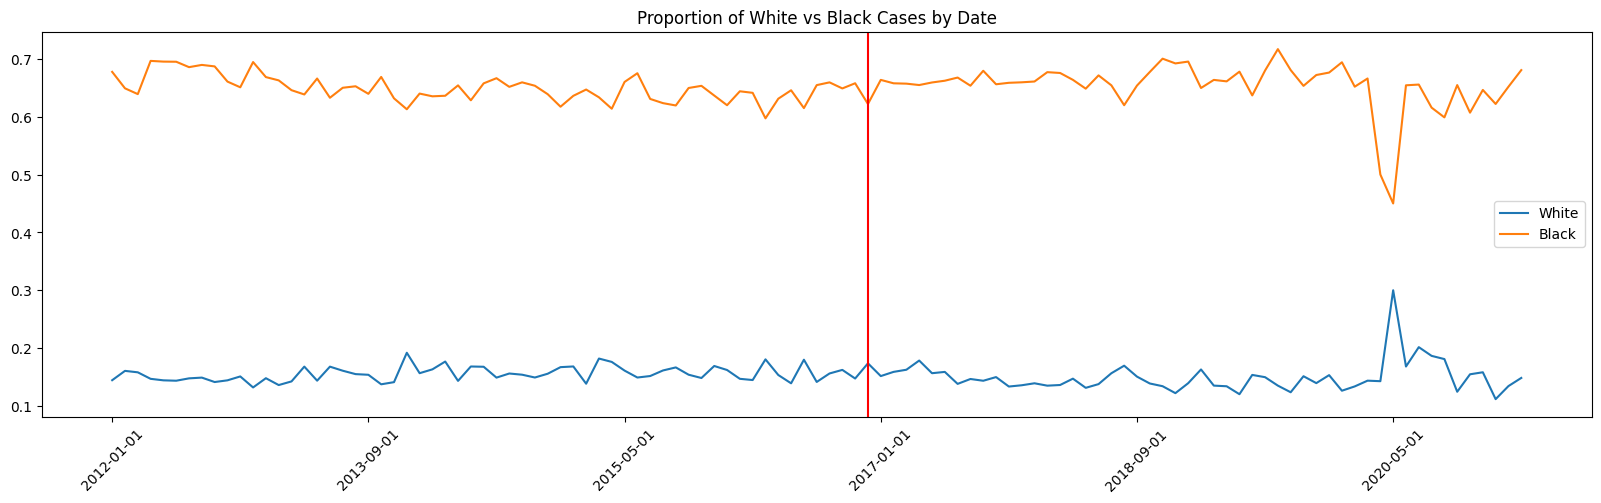

In [21]:
# your code here
import matplotlib.dates as mdates

foxx_index = racial_props.index[racial_props['sentenceym_derived'] == "2016-12-01"]

ax = racial_props.plot(x = "sentenceym_derived", y = ["white_props", "black_props"], rot=45, title="Proportion of White vs Black Cases by Date", figsize=(20, 5), kind = "line")
plt.xlabel("")
plt.legend(["White", "Black"])
plt.axvline(x = foxx_index, color = 'red')
plt.show()

$whiteProps = \frac{\sum_{i}^{n}whiteCases}{totalCases}$ where whiteCases is the number of white cases for each month for all n months and $blackProps = \frac{\sum_{i}^{m}blackCases}{totalCases}$ where blackCases is the number of black cases for each month for for all m months. In April and May 2022, the proportion of black cases decreases and the proportion of white cases increases. This coincides with George Floyd's death and the protests that followed.

## 2.2.0 Investigating mechanisms: incarceration rates by charge (21 points total)

Your colleague sees the previous graph and is worried that the gap could be different---either wider or smaller---if you adjust for the fact that prosecutors have discretion in what crimes to charge defendants with. If white defendants are charged with crimes that tend to receive probation rather than incarceration, that could explain some of the gaps.

In the next questions, you'll begin to investigate this.

### 2.2.1 Find the most common offenses (3 points)

First, based on `simplified_offense_derived`, create a set of 'frequent offenses' that represent (over the entire period) the union of the 10 offenses Black defendant are most likely to be charged with and the 10 offenses white defendants are most likely to be charged with (might be far less than 20 total if there's a lot of overlap in common charges)

**Hint:** To get the unique elements of a list (i.e., remove overlaps), create a `set()`, which only stores unique values (syntax slightly different than with lists).

**Concepts tested and resources:**

- Row subsetting and sorting, as covered in [these lecture slides on data wrangling](https://github.com/jhaber-zz/QSS20_public/blob/main/slides/03_qss20_w23_pandas.pdf), [the class activity on data wrangling](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/01_pandas_blank.ipynb) and its [solutions](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/solutions/01_pandas_solutions.ipynb), and [the DataCamp on Data Manipulation with Pandas](https://app.datacamp.com/learn/courses/data-manipulation-with-pandas)

In [22]:
# your code here
frequent_offenses_black = sentencing_cleaned.query("is_black_derived == True").agg({"simplified_offense_derived" : "value_counts"}).sort_values("simplified_offense_derived", ascending=False).head(10)["simplified_offense_derived"].index.tolist()
frequent_offenses_white = sentencing_cleaned.query("is_white_derived == True").agg({"simplified_offense_derived" : "value_counts"}).sort_values("simplified_offense_derived", ascending=False).head(10)["simplified_offense_derived"].index.tolist()

frequent_offenses = set(frequent_offenses_black + frequent_offenses_white)
print(frequent_offenses)


{'Vehicle-related', 'Other Offense', 'Narcotics', 'Burglary', 'Robbery', 'Retail Theft', 'Driving With Suspended Or Revoked License', 'Battery', 'DUI', 'UUW - Unlawful Use of Weapon', 'Theft', 'Residential Burglary'}


### 2.2.2 Look at incarceration rates (whether incarcerated) by race and offense type for these top offenses (3 points)

Print a wide-format version of the resulting table (so each row is an offense type, one column is black incarceration rate for that offense type, and another column is the white incarceration rate) and interpret. What offenses show the largest disparities in judges being less likely to sentence White defendants to incarceration/more likely to offer those defendants probation?

According to the codebook, incarceration is indicated by `COMMITMENT_TYPE` == "Illinois Department of Corrections".

**Hint:** To create a wide-format version of a table, one option is [`pd.pivot_table()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot_table.html). 

**Concepts tested and resources:**

- Recoding columns using logical conditions (e.g., with np.where) and groupby with agg, as covered in [these lecture slides on data wrangling](https://github.com/jhaber-zz/QSS20_public/blob/main/slides/03_qss20_w23_pandas.pdf) and [the class activity on data wrangling](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/01_pandas_blank.ipynb) and its [solutions](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/solutions/01_pandas_solutions.ipynb)

In [23]:
# your code here
sentencing_cleaned["incarcerated"] = np.where(sentencing_cleaned["COMMITMENT_TYPE"] == "Illinois Department of Corrections", True, False)

incarceration_rates = pd.DataFrame()
incarceration_rates["OFFENSE_TYPE"] = list(frequent_offenses)

incarceration_rates["black_props"] = [sentencing_cleaned[(sentencing_cleaned["simplified_offense_derived"] == offense) & (sentencing_cleaned["is_black_derived"] == True)].agg({"incarcerated" : "mean"})["incarcerated"] for offense in incarceration_rates["OFFENSE_TYPE"]]

incarceration_rates["white_props"] = [sentencing_cleaned[(sentencing_cleaned["simplified_offense_derived"] == offense) & (sentencing_cleaned["is_white_derived"] == True)].agg({"incarcerated" : "mean"})["incarcerated"] for offense in incarceration_rates["OFFENSE_TYPE"]]

incarceration_rates["disparity"] = incarceration_rates["black_props"] - incarceration_rates["white_props"]

incarceration_rates.sort_values("disparity", ascending=False)

,OFFENSE_TYPE,black_props,white_props,disparity
2,Narcotics,0.537876,0.242535,0.295341
7,Battery,0.509032,0.275552,0.233480
9,UUW - Unlawful Use of Weapon,0.696191,0.481973,0.214217
5,Retail Theft,0.595713,0.449582,0.146132
3,Burglary,0.661927,0.535763,0.126164
1,Other Offense,0.340580,0.230228,0.110351
6,Driving With Suspended Or Revoked License,0.582193,0.496552,0.085642
10,Theft,0.386961,0.318721,0.068240
11,Residential Burglary,0.717791,0.654114,0.063677
8,DUI,0.404997,0.341855,0.063143


Most of the offenses which represent the most incarcerations for both black and white people in Chicago show a disparity where black people are incarcerated at a higher rate than white people. The largest difference is Narcotics charges, where black people are incarcerated at a rate 30% higher than white people. Black people are also incarcerated at a rate over 20% higher than white people for Battery and UUW charges. The only charge where white people are incarcerated at a higher rate than black people is on Vehicle-related charges, where they are incarcerated about 3% more often.

### 2.2.3 Examine whether this changes pre and post change to charging threshold for retail theft (10 points)

One important question is not only whether there are disparities by offense type, but also whether these disparities have changed over time.

For instance, the SAO (State Attorney Office) announced in December of 2016 that they would no longer default to charging retail thefts of under \$1,000 as felonies. This change might have (1) decreased disparities or (2) increased disparities, depending on the correlation between race/ethnicity and magnitude of goods stolen (see [this article](https://www.dnainfo.com/chicago/20161215/little-village/kim-foxx-raises-bar-for-retail-theft-felonies/) for more background). 

Focusing on `simplified_offense_derived` == "Retail theft", write a user-defined function that allows you to efficiently: 

- Compare Black-White disparities before and after the change using a two-month bandwidth (so pre is October and November 2016; post is January and February 2017)

- Compare Black-White disparities before and after the change using a four-month bandwidth (so pre is August- November 2016; post is January - April 2017)

- Compare Black-White disparities using an eight-month bandwidth

- Compare Black-White disparities using a twelve-month bandwidth

In other words, the function should compare percentages of defendants incarcerated for retail theft by race. The numerator in the proportions is the # of defendants incarcerated for retail theft, the denom is # of total defendants for retail theft (calculate this separately for each race and separately for before versus after); disparity is the difference in proportions.

Exclude Dec. 2016 as a transition month.

------------------ 

Print a table with the results (any organization is fine as long as it's clear).
 
------------------ 
 
**Concepts tested and resources**:
    
- User-defined functions and list comprehensions, as will be covered in class on 01/18 in [these slides](https://github.com/jhaber-zz/QSS20_public/blob/main/slides/04_qss20_w23_userdefinedfunctions.pdf) and [the functions activity](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/02_functions_blank.ipynb) and [its solutions](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/solutions/02_functions_solutions.ipynb) (forthcoming on 01/18)

- Row subsetting with logical conditions (e.g., with np.where), as covered in [these lecture slides on data wrangling](https://github.com/jhaber-zz/QSS20_public/blob/main/slides/03_qss20_w23_pandas.pdf) and [the class activity on data wrangling](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/01_pandas_blank.ipynb) and its [solutions](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/solutions/01_pandas_solutions.ipynb)

- Visualization, as covered in [this plotnine example code](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/01_plotting_examples_plotnine.ipynb), chapter 4 of [the DataCamp course on Data Manipulation with Pandas](https://app.datacamp.com/learn/courses/data-manipulation-with-pandas), and the optional DataCamp courses on Data Visualization with ggplot2/Matplotlib

**Hints on function:** Your function should take these steps:

1. Create a December 2016 object and use that to create a range corresponding to the bandwidth.
2. Filter to rows within December 2016 +- that # of months. For example, for the 2-month bandwidth, the "before" period is Oct and Nov 2016; after is Jan and Feb 2017. Instead of using timedelta to increment in time (as we did in class function activity), use [**relativedelta**](https://dateutil.readthedocs.io/en/stable/relativedelta.html) to increment in months.
3. Within that filtered dataset, examine Black-White disparities in incarceration before versus after. One shortcut for doing this is to keep the full dataframe together and construct an `is_after` indicator (e.g., using `np.where()`) that takes the value of `True` if after Dec 2016 (and otherwise is `False`), and then group by that and a categorical race variable. This step produces a single dataframe for each time window--e.g., a dataframe for the 2-month bandwidth, a dataframe for the 4-month one, etc. 
4. Use `pd.concat` to combine those dataframes into a single dataframe.

**Hint on output:** The table you make should have two Black-white disparities per bandwidth: one disparity (e.g., a 10 percentage point difference in incarceration rates) before the policy change and another disparity after (e.g., a 5 percentage point difference in incarceration rates). 

In [24]:
# your code here
def retailTheftRacialDisparity():
    """
    Function which inspects racial disparity of incarceration rates for retail thefts in Chicago, IL before and after a law change in December 2016 at various bandwidths.

    Returns:
        pandas.DataFrame: DataFrame with columns "months_bandwidth", "black_props_pre", "black_props_post", "white_props_pre", "white_props_post", "black_disparity_pre", "black_disparity_post", "white_disparity_pre", "white_disparity_post"
    """
    centerDate = pd.to_datetime("2016-12-01")
    bandwidths = [2, 4, 8, 12]
    retail_thefts = sentencing_cleaned.query("simplified_offense_derived == 'Retail Theft'")

    retail_theft_disparity = pd.DataFrame()
    retail_theft_disparity["months_bandwidth"] = [str(bandwidth)+" Months" for bandwidth in bandwidths]

    retail_theft_disparity["black_props_pre"] = [retail_thefts[(pd.to_datetime(retail_thefts["sentenceym_derived"]) < centerDate) & (pd.to_datetime(retail_thefts["sentenceym_derived"]) >= centerDate - pd.DateOffset(months=bandwidth)) & (retail_thefts["is_black_derived"] == True)].agg({"incarcerated" : "mean"})["incarcerated"] for bandwidth in bandwidths]
    retail_theft_disparity["white_props_pre"] = [retail_thefts[(pd.to_datetime(retail_thefts["sentenceym_derived"]) < centerDate) & (pd.to_datetime(retail_thefts["sentenceym_derived"]) >= centerDate - pd.DateOffset(months=bandwidth)) & (retail_thefts["is_white_derived"] == True)].agg({"incarcerated" : "mean"})["incarcerated"] for bandwidth in bandwidths]
    retail_theft_disparity["disparity_pre"] = retail_theft_disparity["black_props_pre"] - retail_theft_disparity["white_props_pre"]

    retail_theft_disparity["black_props_post"] = [retail_thefts[(pd.to_datetime(retail_thefts["sentenceym_derived"]) > centerDate) & (pd.to_datetime(retail_thefts["sentenceym_derived"]) <= centerDate + pd.DateOffset(months=bandwidth)) & (retail_thefts["is_black_derived"] == True)].agg({"incarcerated" : "mean"})["incarcerated"] for bandwidth in bandwidths]
    retail_theft_disparity["white_props_post"] = [retail_thefts[(pd.to_datetime(retail_thefts["sentenceym_derived"]) > centerDate) & (pd.to_datetime(retail_thefts["sentenceym_derived"]) <= centerDate + pd.DateOffset(months=bandwidth)) & (retail_thefts["is_white_derived"] == True)].agg({"incarcerated" : "mean"})["incarcerated"] for bandwidth in bandwidths]
    retail_theft_disparity["disparity_post"] = retail_theft_disparity["black_props_post"] - retail_theft_disparity["white_props_post"]
    
    return retail_theft_disparity
    
retail_theft_disparity = retailTheftRacialDisparity()
retail_theft_disparity

,months_bandwidth,black_props_pre,white_props_pre,disparity_pre,black_props_post,white_props_post,disparity_post
0,2 Months,0.626374,0.538462,0.087912,0.372340,0.217391,0.154949
1,4 Months,0.558511,0.476923,0.081588,0.411972,0.330357,0.081615
2,8 Months,0.568990,0.436090,0.132900,0.493450,0.450000,0.043450
3,12 Months,0.580889,0.419271,0.161618,0.510714,0.446009,0.064705


### 2.2.4 Visualize the above (4 points)

Use the table you just made to create a bar chart, where the x axis represents different bandwidths (2, 4, etc); the y axis the size of the Black-White gap, and for each of the x axis points, you have one shaded bar representing "before" the change, another representing "after" the change (make sure that before is ordered before after and the bandwidths are from smallest to largest)


**Hints**: 

- For each of the bandwidths, include dates spanning the entire month: e.g., for the first, include not only 02-01-2017 but everything up through 02-28-2017; easiest way is for the subsetting to use the rounded `sentenceym_derived`. Also make sure to only include white or black defendants.

- Depending on how you calculate/reshape things, you may find [this issue useful for how to collapse column names with a multilevel index](https://stackoverflow.com/questions/24290297/pandas-dataframe-with-multiindex-column-merge-levels) (also may not need it depending on how you structure the code).

- The x-axis on the plot should be a categorical variable, with each of the bandwidths and with separate bars for before vs. after. If you want to change the order of the categories, [check out the `reorder_categories` function in this SO issue](https://stackoverflow.com/questions/38023881/pandas-change-the-order-of-levels-of-factor-type-object).

**Extra credit** (1 point): because the bandwidths have different sample sizes, a better viz incorporates measures of uncertainty. Add standard errors to the points using the formula: $(\dfrac{p(1-p)}{n})^{0.5}$ where N is the number of cases in each bandwidth period.

<AxesSubplot: title={'center': 'Retail Theft Incarceration Rate Racial Disparity Pre and Post December 2016'}, xlabel='months_bandwidth'>

Text(0.5, 0, 'Bandwidth of Months Inspected')

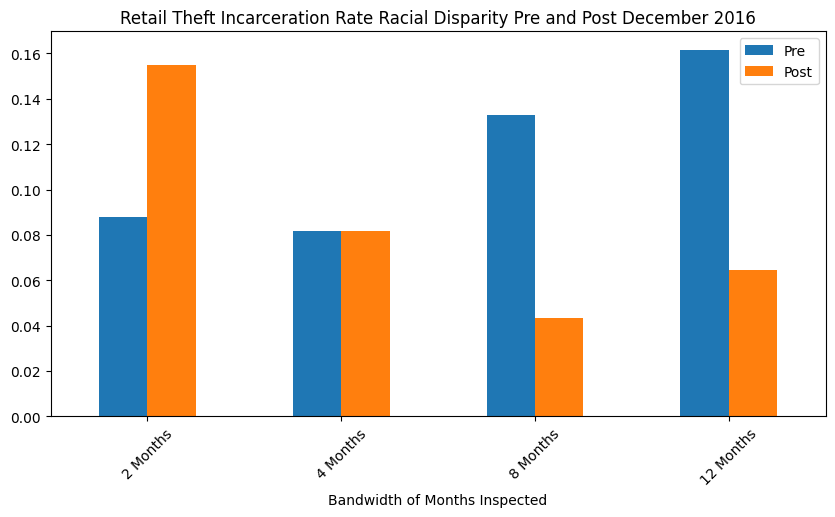

In [25]:
# your code here
retail_theft_disparity.plot(kind = "bar", x="months_bandwidth", y=["disparity_pre", "disparity_post"], figsize=(10, 5), rot = 45, title = "Retail Theft Incarceration Rate Racial Disparity Pre and Post December 2016")
plt.legend(["Pre", "Post"])
plt.xlabel("Bandwidth of Months Inspected")
plt.show()

### 2.2.5 Interpret the results (1 point)

Write a two-sentence interpretation of the results. What might this show about how people on both sides of the issue---those arguing the policy change will narrow disparities; those arguing the change may widen disparities--could support their claims? 

Those arguing the policy change will narrow disparities could point to the fact that the black-white incarceration disparity lessened over the course of 8 months after the policy change. Those arguing the policy change may widen disparities could point to the fact that the black-white incarceration disparity was much greater 2 months after the policy change than 2 months before. 